In [166]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA

In [167]:
lap_times = pd.read_csv('./data/lap_times.csv')

In [168]:
def string_to_seconds(s):
    mins, secs = s.split(":")
    return (float(mins) * 60) + float(secs)

lap_times['TIME'] = lap_times['TIME'].apply(string_to_seconds)

In [169]:
#lap_times = pd.read_csv('./data/lap_times.csv')
tracks = pd.read_csv('./data/track_history.csv')

In [170]:
tracks['TRACK'] = tracks['TRACK'].apply(lambda x: x.lower())
tracks['RACE'] = tracks['TRACK'] + tracks['YEAR'].astype(str)
df = pd.merge(lap_times, tracks, 'left', ['RACE'])

# Pre-processing

In [171]:
## INTUITION

print("Before: {}".format(df.shape))

## Engineered Data, 'AVG_SPEED' : Average speed in the lap.

df['AVG_SPEED'] = (df['LENGTH'] / df['TIME'])  * 3600

## Reduce the features.

df['AIR_TEMP_AVG'] = (df['AIR_TEMP_MAX'] + df['AIR_TEMP_MIN']) / 2
df['TRACK_TEMP_AVG'] = (df['T_TEMP_MAX'] + df['T_TEMP_MIN']) / 2
df.drop(columns = ['AIR_TEMP_MAX', 'AIR_TEMP_MIN', 'T_TEMP_MAX', 'T_TEMP_MIN'], inplace = True)

## Dropping irrelevant features.

df.drop(columns = ['YEAR', 'TRACK'], inplace = True)

## Dropping laps where the driver was lapped.

def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True

df = df[df['GAP'].apply(lambda x: is_float(x))]
df['GAP'] = df['GAP'].astype(float)

## Removing laps on weather tires as they are anomalies.

df = df[~((df['TIRE'] == '') | (df['TIRE'] == 'Intermediate'))]

## Removing the first lap of the stint.

df = df[~(df['STINT_LAP'] == 0)]

## Dropping rows with anomaly lap times.

for race in df['RACE'].unique().tolist():
    mean, std = df[df['RACE'] == race]['TIME'].mean(), df['TIME'].std()
    df[df['RACE'] == race] = df[(df['RACE'] == race) & (mean + std > df['TIME']) & (df['TIME'] > mean - std)]

df.dropna(axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

print("After: {}".format(df.shape))

Before: (23097, 20)
After: (16117, 17)


In [172]:
df.groupby('RACE').first().sort_values('TRACK_TEMP_AVG')

,NO,GAP,TIME,TIRE,LAP,STINT_LAP,LENGTH,LAPS,DOWNFORCE,LATERAL,ASPHALT_ABR,ASPHALT_GRP,TIRE_STRESS,AVG_SPEED,AIR_TEMP_AVG,TRACK_TEMP_AVG
RACE,,,,,,,,,,,,,,,,
usa2015,9.0,64.827,114.207,Soft,17.0,1.0,5.51,56.0,3.0,4.0,3.0,2.0,3.0,173.684625,17.50,18.60
russia2015,33.0,20.784,109.022,Soft,2.0,1.0,5.84,53.0,4.0,5.0,1.0,4.0,2.0,192.841812,18.35,26.80
bahrain2016,6.0,0.000,98.149,Super,1.0,1.0,5.41,57.0,3.0,3.0,5.0,4.0,3.0,198.432995,21.90,27.75
abudhabi2015,6.0,0.000,107.014,Super,1.0,1.0,5.55,55.0,3.0,3.0,2.0,2.0,2.0,186.704543,26.05,28.40
bahrain2015,44.0,0.000,98.955,Soft,1.0,1.0,5.41,57.0,3.0,3.0,5.0,4.0,3.0,196.816735,25.15,29.90
austria2015,6.0,0.000,73.607,Super,6.0,6.0,4.33,71.0,4.0,3.0,1.0,2.0,2.0,211.773337,15.00,31.35
britain2015,14.0,6.193,112.411,Hard,2.0,1.0,5.89,52.0,4.0,5.0,3.0,4.0,5.0,188.629227,18.95,31.40
australia2016,5.0,0.000,91.664,Super,1.0,1.0,5.30,58.0,4.0,1.0,3.0,1.0,1.0,208.151510,23.45,32.60
australia2015,44.0,0.000,93.493,Soft,3.0,3.0,5.30,58.0,4.0,1.0,3.0,1.0,1.0,204.079450,19.00,33.50


In [173]:
vis_df = df[df['RACE'] == 'japan2015'].copy()
race_specific_columns = [
    'RACE',
    'LENGTH',
    'DOWNFORCE',
    'LATERAL',
    'ASPHALT_ABR',
    'ASPHALT_GRP',
    'TIRE_STRESS',
    'AIR_TEMP_AVG',
    'TRACK_TEMP_AVG',
    'AVG_SPEED'
]
vis_df.drop(columns = race_specific_columns, inplace = True)
vis_df.reset_index(inplace=True, drop=True)
display(vis_df.head())
display(vis_df.shape)

,NO,GAP,TIME,TIRE,LAP,STINT_LAP,LAPS
0,44.0,0.000,99.660,Medium,1.0,1.0,53.0
1,5.0,2.230,100.249,Medium,1.0,1.0,53.0
2,77.0,3.717,100.593,Medium,1.0,1.0,53.0
3,6.0,4.761,101.048,Medium,1.0,1.0,53.0
4,7.0,5.677,101.005,Medium,1.0,1.0,53.0


(711, 7)

# Visualization

In [174]:
tire_order = ['Super', 'Soft', 'Medium', 'Hard']

/Users/erenture/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



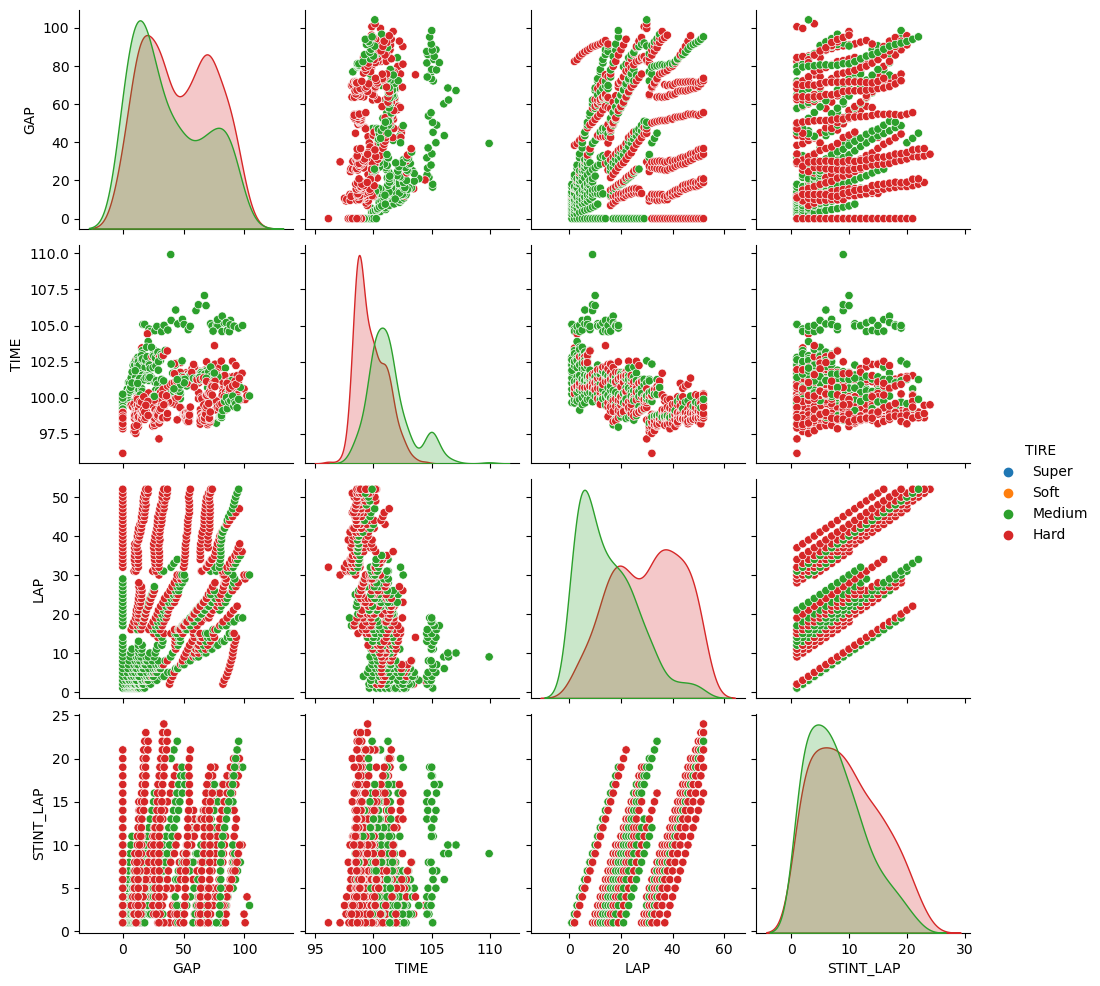

In [175]:
sns.pairplot(vis_df.drop(columns = ['NO', 'LAPS']), hue="TIRE", hue_order = tire_order)
plt.show()

# PCA

In [227]:
def pca_auto(df, race):
    ## SET DATA ##
    vis_df = df[df['RACE'] == race].copy()
    race_specific_columns = [
        'RACE',
        'LENGTH',
        'DOWNFORCE',
        'LATERAL',
        'ASPHALT_ABR',
        'ASPHALT_GRP',
        'TIRE_STRESS',
        'AIR_TEMP_AVG',
        'TRACK_TEMP_AVG',
        'AVG_SPEED'
    ]
    vis_df.drop(columns = race_specific_columns, inplace = True)
    vis_df.reset_index(inplace=True, drop=True)
    
    ## PCA Set-up ##
    pca_X = vis_df[['GAP', 'TIME', 'LAP', 'STINT_LAP']].copy()
    pca_y = vis_df['TIRE'].copy()

    for col in pca_X.columns:
        mean = pca_X[col].mean()
        std = pca_X[col].std()
        pca_X[col] = pca_X[col].apply(lambda x: (x - mean) / std)

    pca_X = pca_X[pca_X['TIME'] <= 4]

    ## VIS ##
    tire_order = ['Super', 'Soft', 'Medium', 'Hard']
    pca_vis_df = pca_X.copy()
    pca_vis_df['TIRE'] = pca_y

    sns.pairplot(pca_vis_df, hue="TIRE", hue_order = tire_order)
    plt.show()

    X = pca_X.to_numpy()
    X.shape
    C = np.dot(X.T, X) / X.shape[0]
    C.shape
    plt.subplots(figsize=(7, 5))
    sns.heatmap(C, annot=True, fmt='.1f', annot_kws={"fontsize": 7},
                xticklabels = pca_X.columns,
                yticklabels = pca_X.columns
                )
    plt.show()

    ## PCA ANALYSIS ##
    pca = PCA()
    tilde_X = pca.fit_transform(pca_X)

    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum() / pca.explained_variance_ratio_.sum())

    plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))

    plt.xlabel('Eigenvalues')
    plt.ylabel('Variance Explained')

    plt.grid()

    plt.show()

    for i, ratio in enumerate(pca.explained_variance_ratio_.cumsum()):
        if ratio >= .8:
            dimensions = i + 1
            break

    pca = PCA(dimensions)
    tilde_X = pca.fit_transform(pca_X)
    V_df = pd.DataFrame(pca.components_, columns = pca_X.columns)

    display(V_df.style.apply(lambda x: ["background: green" if abs(v) > .40 else "" for v in x], axis = 1))


    tX_df = pd.DataFrame(tilde_X, columns=[f"X{i + 1}" for i in range(tilde_X.shape[1])])
    tX_df['TIRE'] = pca_y
    #sns.pairplot(tX_df, hue="TIRE", hue_order = tire_order)
    sns.scatterplot(tX_df, x = "X2", y = "X1",hue="TIRE", hue_order = tire_order)
    plt.show()

In [228]:
df['RACE'].unique()

array(['hungary2015', 'belgium2015', 'italy2015', 'singapore2015',
       'japan2015', 'russia2015', 'usa2015', 'mexico2015', 'brazil2015',
       'abudhabi2015', 'australia2015', 'malaysia2015', 'china2015',
       'bahrain2015', 'spain2015', 'monaco2015', 'canada2015',
       'austria2015', 'britain2015', 'australia2016', 'bahrain2016',
       'china2016'], dtype=object)

/Users/erenture/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



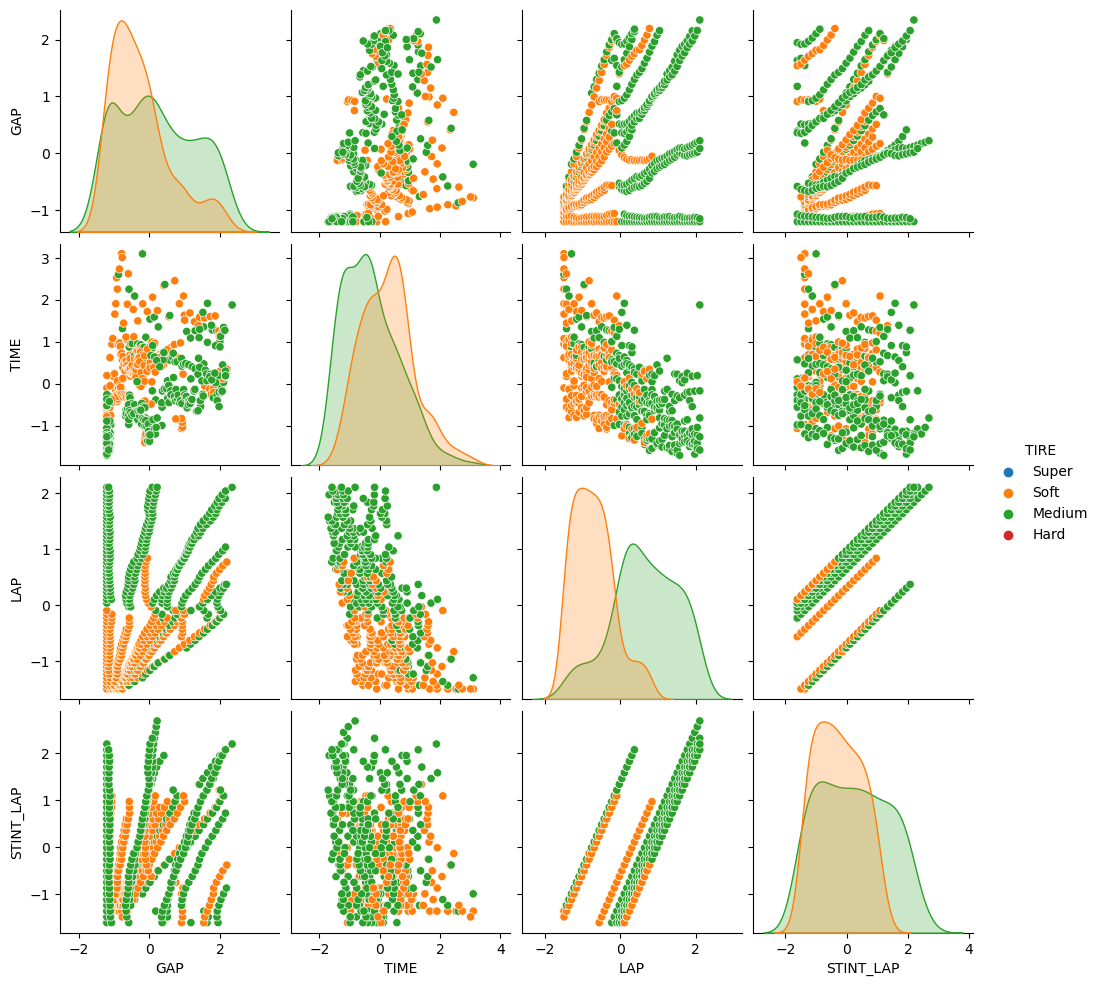

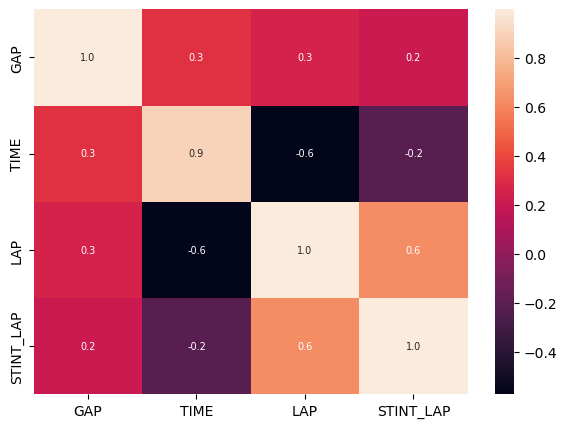

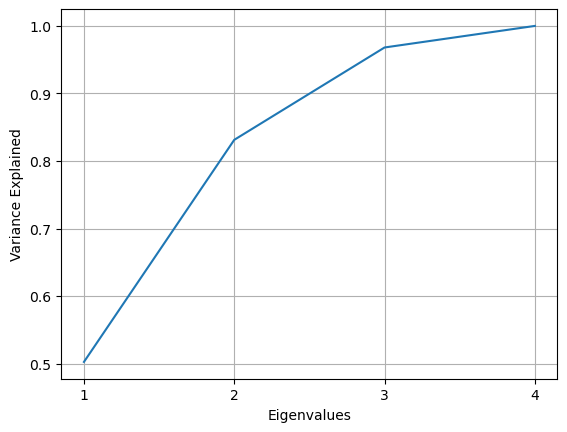

,GAP,TIME,LAP,STINT_LAP
0,0.167372,-0.426883,0.677934,0.574598
1,0.799864,0.570117,0.002551,0.187556


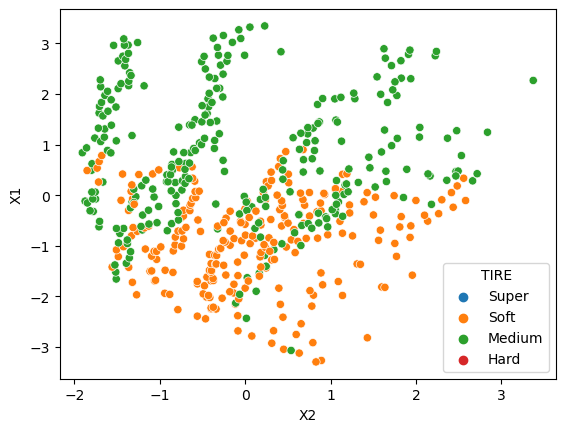

In [229]:
pca_auto(df, race)